In [1]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             f1_score, roc_auc_score, classification_report,
                             make_scorer, accuracy_score)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import optuna
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    Doc
)

c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
username = '...'
password = '...'
host = '...'
port = '...'
database = '...'
conn_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

# Компании

In [3]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe = pd.read_sql_query('SELECT * FROM companies_trade', conn)
conn.close()

print(dataframe.shape)
dataframe.head()

(7267, 17)


,website,section,url,header,body,tags,body_length,datetime,company,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,SBER,142.75,11917688.40,142.62,2958789.90,-0.13,-0.091068,-8958898.5,-75.173122
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,GAZP,163.13,1100961.10,163.37,1413064.30,0.24,0.147122,312103.2,28.348250
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,ROSN,363.70,178263.05,364.85,321423.75,1.15,0.316195,143160.7,80.308679
3,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,SBER,141.31,1573757.40,141.40,2401025.00,0.09,0.063690,827267.6,52.566399
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,GAZP,161.69,4620114.20,161.60,1373716.00,-0.09,-0.055662,-3246398.2,-70.266622


In [2]:
additional_stopwords = [
    'которых', 'которые', 'твой', 'которой', 'которого', 'сих', 'ком', 'свой',
    'твоя', 'этими', 'слишком', 'нами', 'всему', 'будь', 'саму', 'чаще',
    'ваше', 'сами', 'наш', 'затем', 'самих', 'наши', 'ту', 'каждое', 'мочь',
    'весь', 'этим', 'наша', 'своих', 'оба', 'который', 'зато', 'те', 'этих',
    'вся', 'ваш', 'такая', 'теми', 'ею', 'которая', 'нередко', 'каждая',
    'также', 'чему', 'собой', 'самими', 'нем', 'вами', 'ими', 'откуда',
    'такие', 'тому', 'та', 'очень', 'сама', 'нему', 'алло', 'оно', 'этому',
    'кому', 'тобой', 'таки', 'твоё', 'каждые', 'твои', 'нею', 'самим', 'ваши',
    'ваша', 'кем', 'мои', 'однако', 'сразу', 'свое', 'ними', 'всё', 'неё',
    'тех', 'хотя', 'всем', 'тобою', 'тебе', 'одной', 'другие', 'само', 'эта',
    'самой', 'моё', 'своей', 'такое', 'всею', 'будут', 'своего', 'кого',
    'свои', 'мог', 'нам', 'особенно', 'её', 'самому', 'наше', 'кроме',
    'вообще', 'вон', 'мною', 'никто', 'это'
]

stop_words = stopwords.words('russian') + additional_stopwords

In [3]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

ner_tagger = NewsNERTagger(emb)

In [4]:
del_n = re.compile('\n')
del_tags = re.compile('<[^>]*>')
del_brackets = re.compile('\([^)]*\)')
clean_text = re.compile('[^а-яa-z\s]')
del_spaces = re.compile('\s{2,}')


def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    return del_spaces.sub(' ', res_text)


def del_stopwords(text):
    clean_tokens = tuple(
        map(lambda x: x if x not in stop_words else '', word_tokenize(text)))
    res_text = ' '.join(clean_tokens)
    return res_text


def lemmatize(text):
    text = Doc(text)
    text.segment(segmenter)
    text.tag_morph(morph_tagger)
    for token in text.tokens:
        token.lemmatize(morph_vocab)
    text.tag_ner(ner_tagger)
    for span in text.spans:
        span.normalize(morph_vocab)
    return ' '.join([token.lemma for token in text.tokens])

In [7]:
txt_lst = []
txts = dataframe.body.copy()

for text in tqdm(txts):
    text = prepare_text(text)
    text = del_stopwords(text)
    text = lemmatize(text)
    txt_lst.append(text)

  0%|          | 1/7267 [00:00<17:18,  7.00it/s]

100%|██████████| 7267/7267 [04:34<00:00, 26.48it/s]


In [8]:
df_comp_safe = pd.concat(
    [dataframe, pd.DataFrame(txt_lst, columns=['text_clear'])],
    axis=1
)

df_comp_safe.to_csv('texts_comp.csv', index=False)

In [5]:
del_n = re.compile('\n')
del_tags = re.compile('<[^>]*>')
del_brackets = re.compile('\([^)]*\)')
clean_text = re.compile('[^а-яa-z\s]')
del_spaces = re.compile('\s{2,}')


def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    return del_spaces.sub(' ', res_text)

df_comp = pd.read_csv('texts_comp.csv')

for i, text in enumerate(df_comp.text_clear):
    df_comp.loc[i, 'text_clear'] = prepare_text(text).strip()

In [6]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(16, 10))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(
        cm, display_labels=[j - 1 for j in model.classes_])
    cmp.plot(ax=ax)
    plt.show()

In [7]:
p = 0.05

q_l = df_comp.price_diff_percent.quantile(p)
q_u = df_comp.price_diff_percent.quantile(1-p)

df_comp['price_diff_cat'] = 1
df_comp.loc[df_comp['price_diff_percent'] <= q_l, 'price_diff_cat'] = 0
df_comp.loc[df_comp['price_diff_percent'] >= q_u, 'price_diff_cat'] = 2

df_comp[['price_diff_cat']].groupby('price_diff_cat').value_counts()

price_diff_cat
0     364
1    6539
2     364
Name: count, dtype: int64

In [8]:
df_comp.describe()

,body_length,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent,price_diff_cat
count,7267.000000,7267.000000,7.267000e+03,7267.000000,7.267000e+03,7267.000000,7267.000000,7.267000e+03,7267.000000,7267.000000
mean,1952.959543,1491.862511,7.887541e+06,1491.773309,5.721324e+06,-0.089202,0.002461,-2.166217e+06,528.523294,1.000000
std,1804.111893,3225.549159,3.161944e+07,3225.317056,2.021367e+07,14.817624,0.521579,2.656147e+07,5328.539323,0.316532
min,202.000000,0.003740,2.494000e+02,0.003700,1.628900e+02,-708.500000,-5.813333,-6.565861e+08,-99.991628,0.000000
25%,997.000000,71.025000,2.371487e+05,71.000000,1.793270e+05,-0.400000,-0.164353,-1.513370e+06,-73.011939,1.000000
50%,1496.000000,255.700000,1.192395e+06,256.000000,9.488263e+05,0.000000,0.000000,-4.558780e+04,-20.351958,1.000000
75%,2338.000000,1281.000000,4.804763e+06,1281.000000,4.029187e+06,0.380000,0.154965,5.952707e+05,138.065313,1.000000
max,32767.000000,49320.000000,1.033405e+09,49400.000000,6.271164e+08,280.000000,9.756098,3.439704e+08,278627.457343,2.000000


In [9]:
X, y = np.array(df_comp['text_clear']), np.array(df_comp['price_diff_cat'].values)

In [10]:
vectorizer = TfidfVectorizer(min_df=50)
vect_x = vectorizer.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(vect_x,
                                                    y,
                                                    random_state=23,
                                                    test_size=0.25,
                                                    stratify=y)

X_res, Y_res = X_train, y_train

In [12]:
train_x, valid_x, train_y, valid_y = train_test_split(X_res,
                                                      Y_res,
                                                      random_state=23,
                                                      test_size=0.25,
                                                      stratify=Y_res)

## SVC

In [13]:
def objective(trial):
    svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    svc_degree = trial.suggest_int('degree', 2, 5, 1, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    svc_c = trial.suggest_float("C", 1e-2, 1e2, log=True)
    clf = SVC(C=svc_c, gamma=svc_gamma, degree=svc_degree, kernel=svc_kernel)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [14]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="svc", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.43263509203572076
  Params: 
    kernel: linear
    degree: 2
    gamma: scale
    C: 18.578492002801674


0.3984823250500287


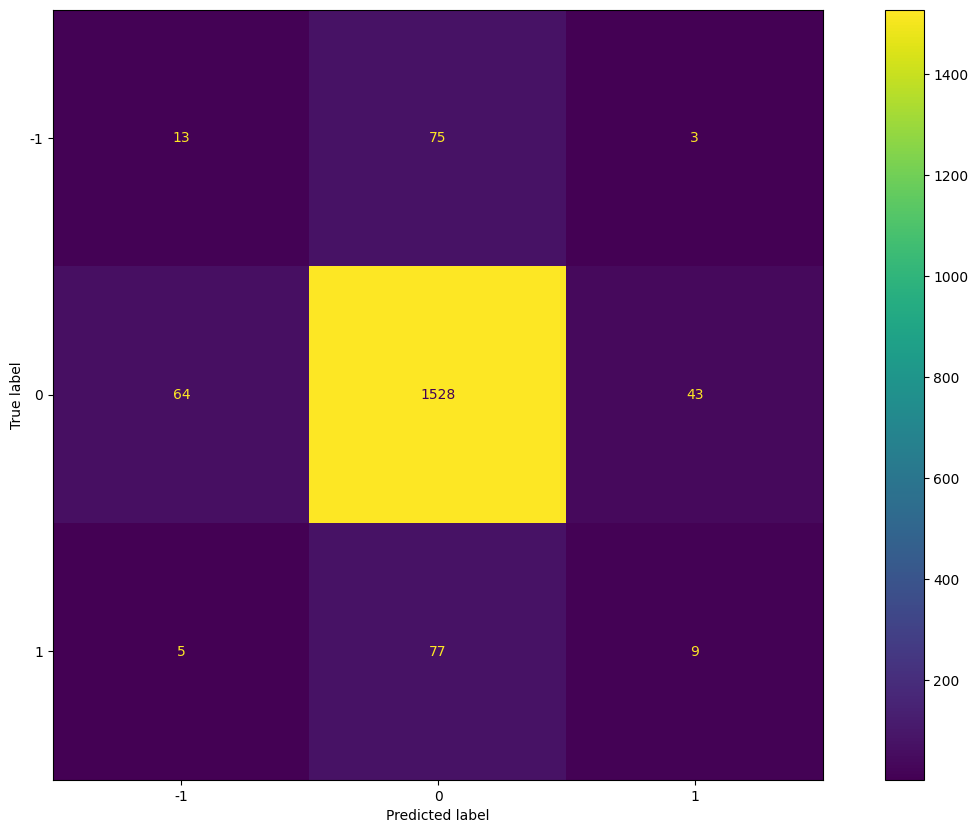

In [15]:
clf = SVC(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## KNN

In [16]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 3, 15, 1, log=True)
    knn_weights = trial.suggest_categorical('weights', ['uniform','distance'])
    knn_metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    clf = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [17]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="knn", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\maxod\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxod\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\maxod\AppData\Local\Programs\

Number of finished trials:  100
Best trial:
  Value: 0.4293735130848533
  Params: 
    n_neighbors: 4
    weights: distance
    metric: euclidean


## LogReg

In [18]:
def objective(trial):
    logreg_solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga','lbfgs'])
    logereg_C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    clf = LogisticRegression(multi_class='multinomial', solver=logreg_solver, C=logereg_C, max_iter=1000)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [19]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="logreg", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.4297652866302657
  Params: 
    solver: lbfgs
    C: 44.87157213103335


c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.39141788400100425


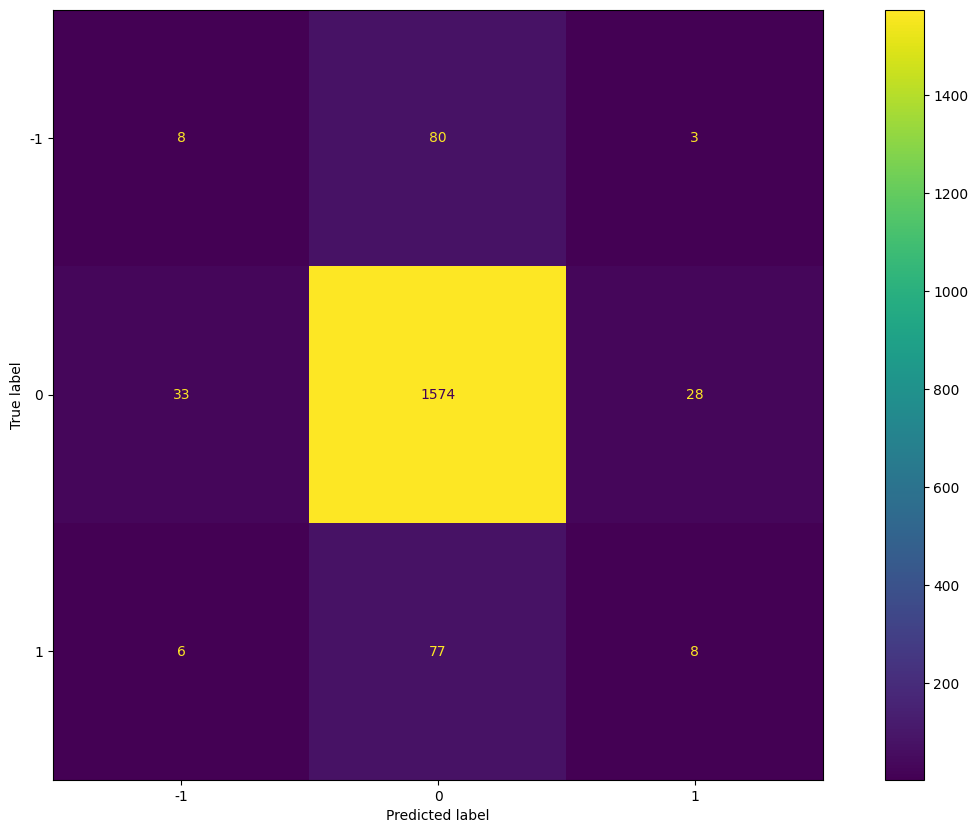

In [20]:
clf = LogisticRegression(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## RandomForest

In [21]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, log=True)
    max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [22]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="rf", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.43322228737663254
  Params: 
    n_estimators: 224
    max_depth: 11
    class_weight: balanced_subsample


0.3942422806601911


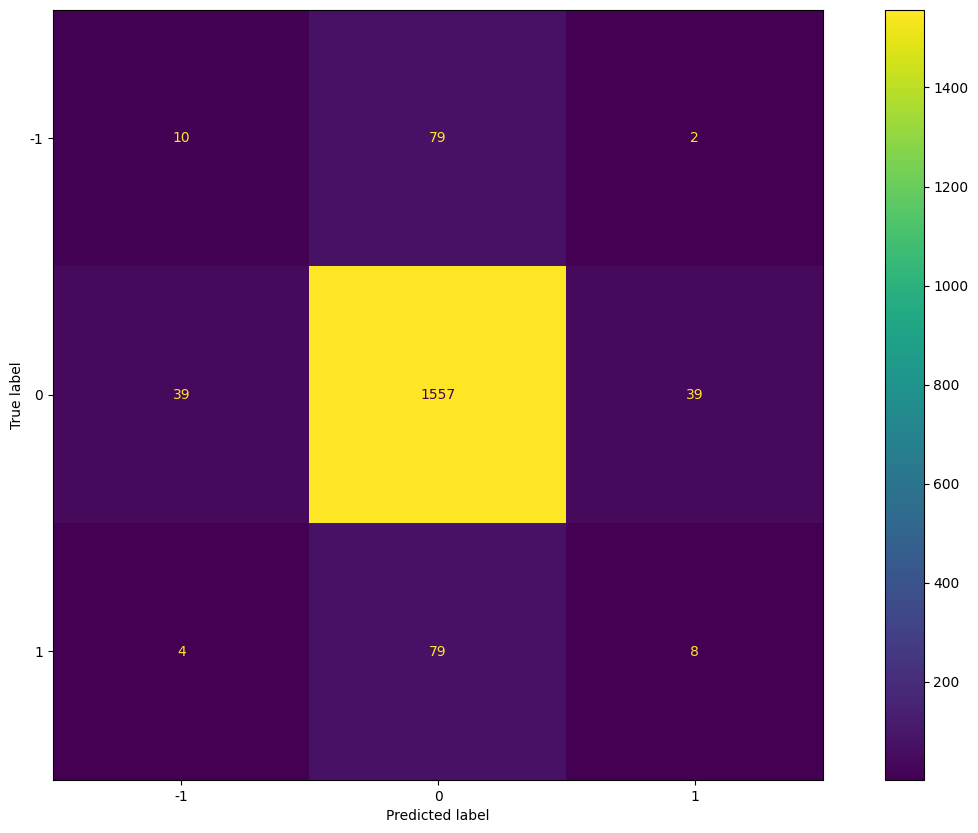

In [23]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

# Индустрии

In [29]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe_ind = pd.read_sql_query('SELECT * FROM industries_trade', conn)
conn.close()

print(dataframe_ind.shape)
dataframe_ind.head()

(4755, 17)


,website,section,url,header,body,tags,body_length,datetime,industry,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,MOEXFN,6307.20,16806757.15,6308.77,11854100.00,1.57,0.024892,-4952657.15,-29.468250
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,MOEXOG,5696.30,4451180.75,5696.72,4605859.35,0.42,0.007373,154678.60,3.475002
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,MOEXOG,5655.65,3325798.35,5663.65,1490555.35,8.00,0.141451,-1835243.00,-55.182029
3,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXFN,6298.36,7394623.45,6296.27,3371524.05,-2.09,-0.033183,-4023099.40,-54.405737
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXOG,5655.00,15940301.65,5647.93,1358915.70,-7.07,-0.125022,-14581385.95,-91.474969


In [30]:
txt_lst = []
txts = dataframe_ind.body.copy()

for text in tqdm(txts):
    text = prepare_text(text)
    text = del_stopwords(text)
    text = lemmatize(text)
    txt_lst.append(text)

100%|██████████| 4755/4755 [01:54<00:00, 41.40it/s]


In [31]:
df_ind_safe = pd.concat(
    [dataframe_ind, pd.DataFrame(txt_lst, columns=['text_clear'])],
    axis=1
)

df_ind_safe.to_csv('texts_ind.csv', index=False)

In [24]:
df_ind = pd.read_csv('texts_ind.csv')

for i, text in enumerate(df_ind.text_clear):
    df_ind.loc[i, 'text_clear'] = prepare_text(text).strip()

In [25]:
p = 0.05

q_l = df_ind.price_diff_percent.quantile(p)
q_u = df_ind.price_diff_percent.quantile(1-p)

df_ind['price_diff_cat'] = 1
df_ind.loc[df_ind['price_diff_percent'] <= q_l, 'price_diff_cat'] = 0
df_ind.loc[df_ind['price_diff_percent'] >= q_u, 'price_diff_cat'] = 2

df_ind[['price_diff_cat']].groupby('price_diff_cat').value_counts()

price_diff_cat
0     238
1    4279
2     238
Name: count, dtype: int64

In [26]:
df_ind.describe()

,body_length,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent,price_diff_cat
count,4755.000000,4755.000000,4.755000e+03,4755.000000,4.755000e+03,4755.000000,4755.000000,4.755000e+03,4755.000000,4755.000000
mean,1767.579811,7413.158797,3.820572e+07,7413.186601,3.165379e+07,0.027804,0.002538,-6.551927e+06,95.293698,1.000000
std,1592.462497,5064.177935,7.411692e+07,5063.749307,5.703261e+07,23.365797,0.271261,6.895301e+07,620.845172,0.316427
min,203.000000,797.340000,4.104400e+03,796.810000,2.542000e+03,-376.840000,-3.976298,-1.091141e+09,-99.930102,0.000000
25%,939.000000,6006.255000,6.628012e+06,6009.615000,5.992865e+06,-6.470000,-0.107233,-1.340766e+07,-56.462377,1.000000
50%,1409.000000,7280.860000,1.627919e+07,7281.670000,1.497770e+07,0.230000,0.004961,-1.035134e+06,-15.995331,1.000000
75%,2158.500000,8587.900000,3.964378e+07,8582.270000,3.357984e+07,7.570000,0.119216,5.404258e+06,65.988172,1.000000
max,32767.000000,42515.650000,1.212407e+09,42521.770000,1.029316e+09,390.430000,1.959216,7.443854e+08,22259.393510,2.000000


In [27]:
X, y = np.array(df_ind['text_clear']), np.array(df_ind['price_diff_cat'].values)

In [28]:
vectorizer = TfidfVectorizer(min_df=50)
vect_x = vectorizer.fit_transform(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(vect_x,
                                                    y,
                                                    random_state=23,
                                                    test_size=0.25,
                                                    stratify=y)

X_res, Y_res = X_train, y_train

In [30]:
train_x, valid_x, train_y, valid_y = train_test_split(X_res,
                                                      Y_res,
                                                      random_state=23,
                                                      test_size=0.25,
                                                      stratify=Y_res)

## SVC

In [31]:
def objective(trial):
    svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    svc_degree = trial.suggest_int('degree', 2, 5, 1, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    svc_c = trial.suggest_float("C", 1e-2, 1e2, log=True)
    clf = SVC(C=svc_c, gamma=svc_gamma, degree=svc_degree, kernel=svc_kernel)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [32]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="svc", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.37950807603781217
  Params: 
    kernel: linear
    degree: 5
    gamma: scale
    C: 13.356277865163404


0.3649424323332078


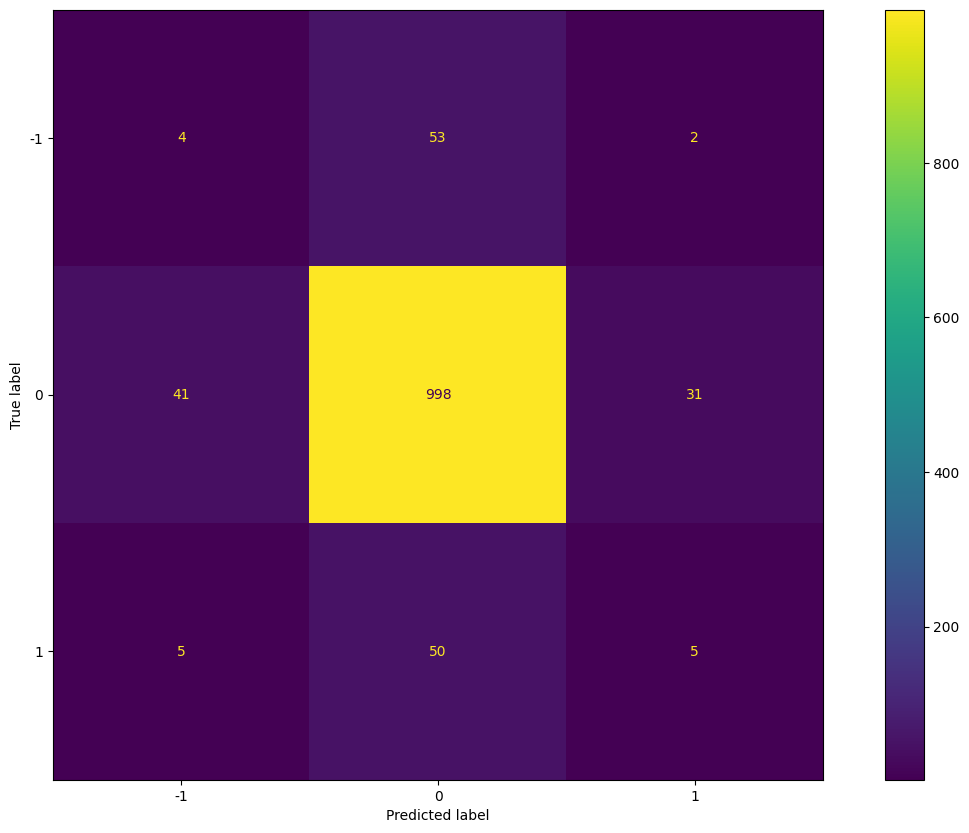

In [33]:
clf = SVC(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## KNN

In [34]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 3, 15, 1, log=True)
    knn_weights = trial.suggest_categorical('weights', ['uniform','distance'])
    knn_metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    clf = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [35]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="knn", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.3852472089314194
  Params: 
    n_neighbors: 4
    weights: distance
    metric: manhattan


0.3645750249523834


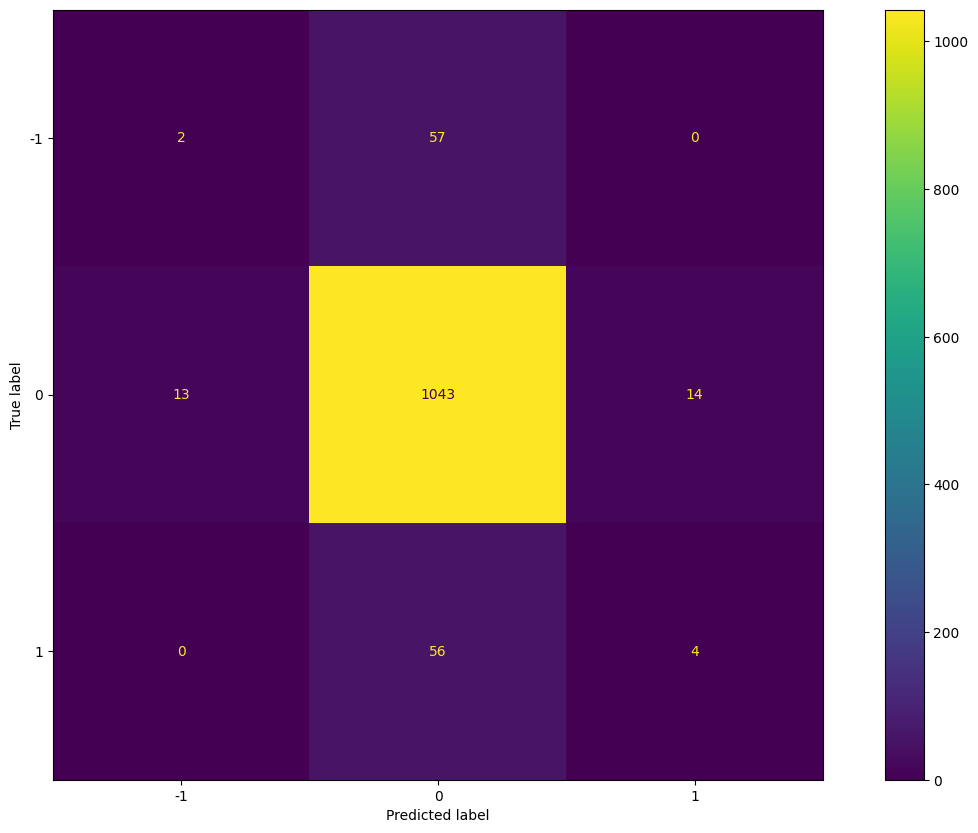

In [36]:
clf = KNeighborsClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## LogReg

In [37]:
def objective(trial):
    logreg_solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga','lbfgs'])
    logereg_C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    clf = LogisticRegression(multi_class='multinomial', solver=logreg_solver, C=logereg_C, max_iter=1000)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [38]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="logreg", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.370676725657693
  Params: 
    solver: newton-cg
    C: 95.55177992061044


0.3537418222133022


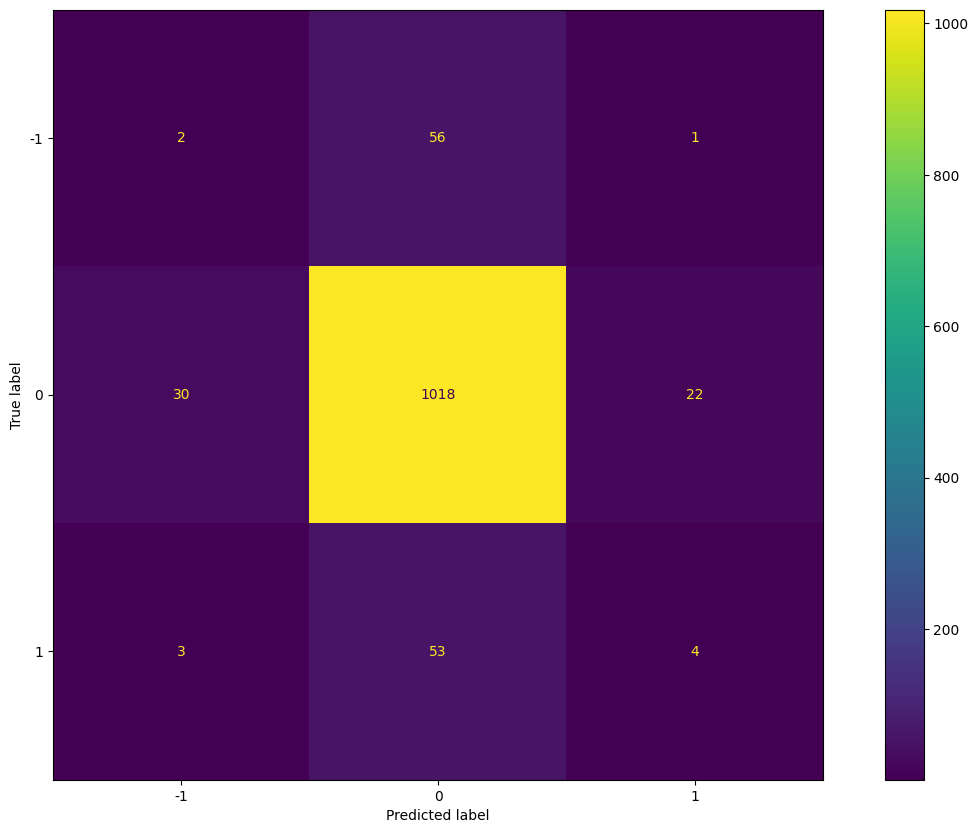

In [39]:
clf = LogisticRegression(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## RandomForest

In [40]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, log=True)
    max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [41]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="rf", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.3667941717855318
  Params: 
    n_estimators: 188
    max_depth: 79
    class_weight: balanced


0.3489290031647718


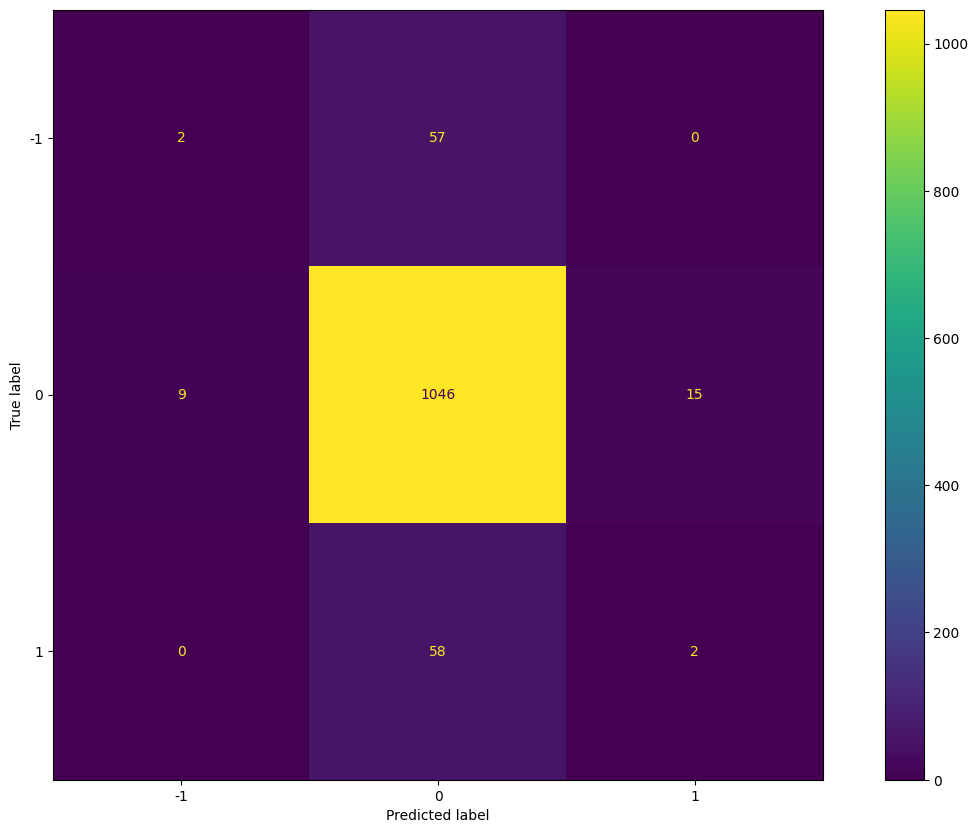

In [42]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## Общий рынок - IMOEX

In [51]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe_global = pd.read_sql_query('SELECT * FROM global_trade', conn)
conn.close()

print(dataframe_global.shape)
dataframe_global.head()

(13304, 20)


,website,section,url,header,body,tags,body_length,datetime,imoex_price_release,imoex_price_lag_30,rvi_price_release,rvi_price_lag_30,usd_price_release,usd_price_lag_30,imoex_price_diff,imoex_price_diff_percent,rvi_price_diff,rvi_price_diff_percent,usd_price_diff,usd_price_diff_percent
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,2166.77,2168.03,40.45,40.26,70352.0,69975.0,1.26,0.058151,-0.19,-0.469716,-377.0,-0.535877
1,РИА,Экономика,https://ria.ru/20230103/avtomobili-1842908567....,Минпромторг спрогнозировал рост производства а...,Минпромторг прогнозирует в наступившем году ...,"['Экономика', 'Авто', 'Денис Мантуров', 'Росси...",808,2023-01-03 10:20:00,2166.37,2167.18,40.45,40.25,70264.0,70008.0,0.81,0.037390,-0.20,-0.494438,-256.0,-0.364340
2,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879539,Рынок акций РФ открылся ростом индекса МосБирж...,- Рынок акций РФ открылся во вторник ростом ...,['Московская биржа'],1249,2023-01-03 10:22:00,2166.08,2166.96,40.45,40.24,70176.0,70017.0,0.88,0.040626,-0.21,-0.519159,-159.0,-0.226573
3,РИА,Экономика,https://ria.ru/20230103/nissan-1842909188.html,"""АвтоВАЗу"" передадут активы Nissan в России","Подведомственное Минпромторгу ФГУП ""НАМИ"" пе...","['Экономика', 'Авто', 'Денис Мантуров', 'Минис...",1414,2023-01-03 10:29:00,2168.32,2168.95,39.86,40.22,70051.0,70144.0,0.63,0.029055,0.36,0.903161,93.0,0.132760
4,Kommersant,Финансы,https://www.kommersant.ru/doc/5757823,"Индекс Мосбиржи растет на 0,5% на первой торго...",Индекс Московской биржи на открытии торгов рас...,None,598,2023-01-03 10:31:00,2168.03,2170.54,39.89,40.13,69940.0,70053.0,2.51,0.115773,0.24,0.601655,113.0,0.161567


In [52]:
txt_lst = []
txts = dataframe_global.body.copy()

for text in tqdm(txts):
    text = prepare_text(text)
    text = del_stopwords(text)
    text = lemmatize(text)
    txt_lst.append(text)

100%|██████████| 13304/13304 [06:02<00:00, 36.67it/s]


In [53]:
df_global_safe = pd.concat(
    [dataframe_global, pd.DataFrame(txt_lst, columns=['text_clear'])],
    axis=1
)

df_global_safe.to_csv('texts_global.csv', index=False)

In [43]:
df_global = pd.read_csv('texts_global.csv')

for i, text in enumerate(df_global.text_clear):
    df_global.loc[i, 'text_clear'] = prepare_text(text).strip()

In [44]:
p = 0.05

q_l = df_global.imoex_price_diff_percent.quantile(p)
q_u = df_global.imoex_price_diff_percent.quantile(1-p)

df_global['imoex_price_diff_cat'] = 1
df_global.loc[df_global['imoex_price_diff_percent'] <= q_l, 'imoex_price_diff_cat'] = 0
df_global.loc[df_global['imoex_price_diff_percent'] >= q_u, 'imoex_price_diff_cat'] = 2

df_global[['imoex_price_diff_cat']].groupby('imoex_price_diff_cat').value_counts()

imoex_price_diff_cat
0      666
1    11972
2      666
Name: count, dtype: int64

In [45]:
X, y = np.array(df_global['text_clear']), np.array(df_global['imoex_price_diff_cat'].values)

In [46]:
vectorizer = TfidfVectorizer(min_df=50)
vect_x = vectorizer.fit_transform(X)

In [47]:
vect_x

<13304x3822 sparse matrix of type '<class 'numpy.float64'>'
	with 1351450 stored elements in Compressed Sparse Row format>

In [48]:
X_train, X_test, y_train, y_test = train_test_split(vect_x,
                                                    y,
                                                    random_state=23,
                                                    test_size=0.25,
                                                    stratify=y)

X_res, Y_res = X_train, y_train

In [49]:
train_x, valid_x, train_y, valid_y = train_test_split(X_res,
                                                      Y_res,
                                                      random_state=23,
                                                      test_size=0.25,
                                                      stratify=Y_res)

## SVC

In [50]:
def objective(trial):
    svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    svc_degree = trial.suggest_int('degree', 2, 5, 1, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    svc_c = trial.suggest_float("C", 1e-2, 1e2, log=True)
    clf = SVC(C=svc_c, gamma=svc_gamma, degree=svc_degree, kernel=svc_kernel)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [51]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="svc", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.3602138555342142
  Params: 
    kernel: poly
    degree: 2
    gamma: scale
    C: 9.775042909523725


0.37184102390613


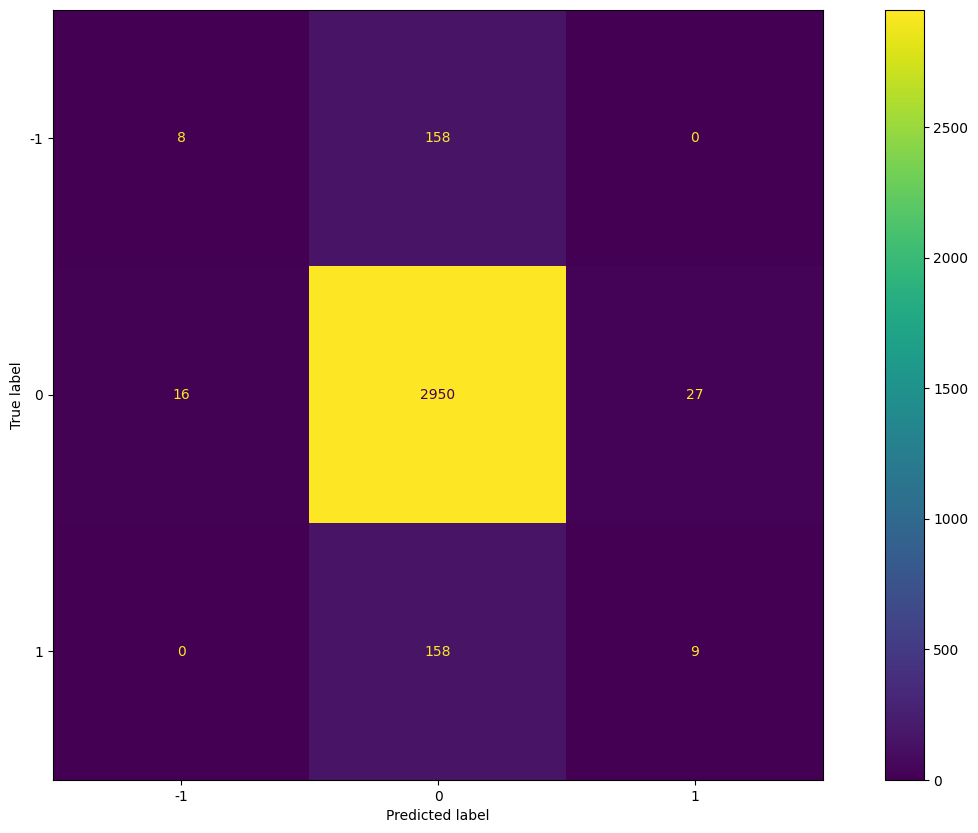

In [52]:
clf = SVC(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## KNN

In [53]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 3, 15, 1, log=True)
    knn_weights = trial.suggest_categorical('weights', ['uniform','distance'])
    knn_metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    clf = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [54]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="knn", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.38352666433928934
  Params: 
    n_neighbors: 4
    weights: distance
    metric: minkowski


0.38019215888556035


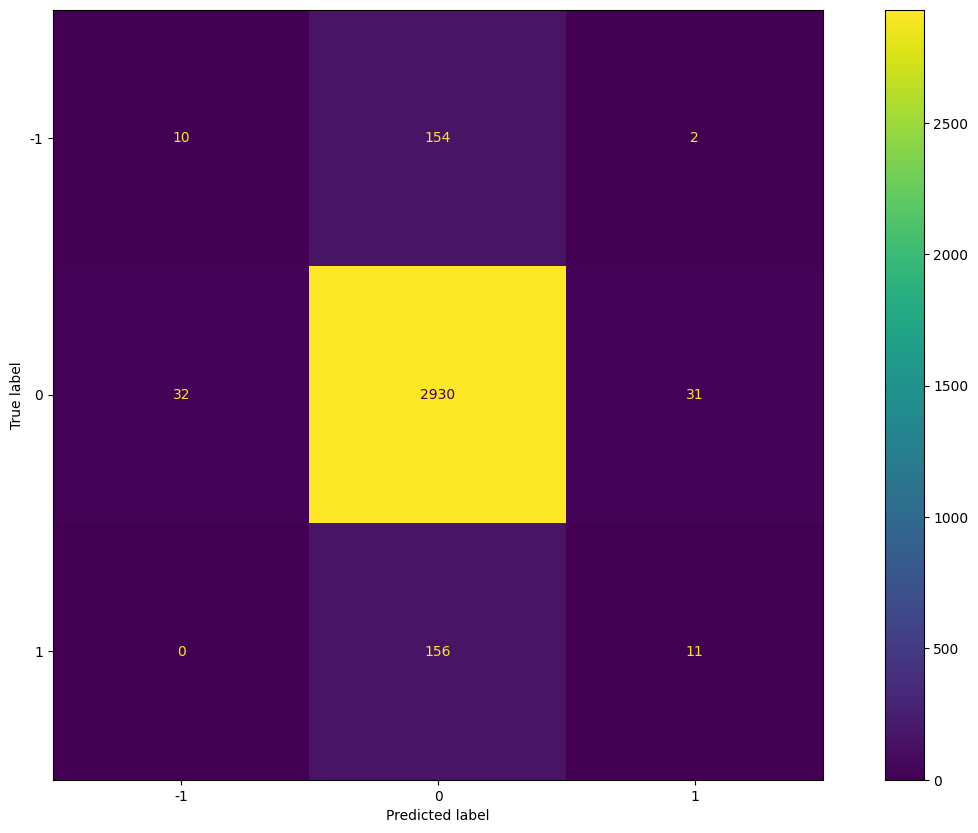

In [55]:
clf = KNeighborsClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## LogReg

In [56]:
def objective(trial):
    logreg_solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga','lbfgs'])
    logereg_C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    clf = LogisticRegression(multi_class='multinomial', solver=logreg_solver, C=logereg_C, max_iter=1000)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [57]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="logreg", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.3486553761521191
  Params: 
    solver: saga
    C: 84.66812532694345


c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.36358186156351296


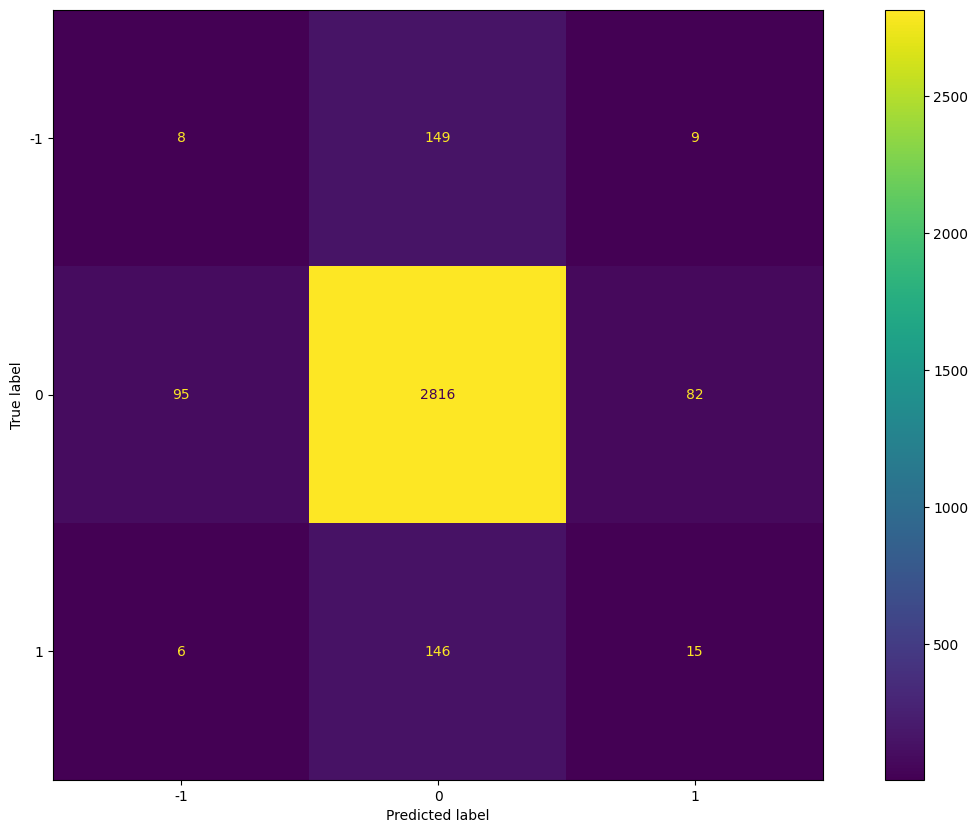

In [58]:
clf = LogisticRegression(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## RandomForest

In [59]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, log=True)
    max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [60]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="rf", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.40021821239923305
  Params: 
    n_estimators: 289
    max_depth: 13
    class_weight: balanced_subsample


0.3418565685514294


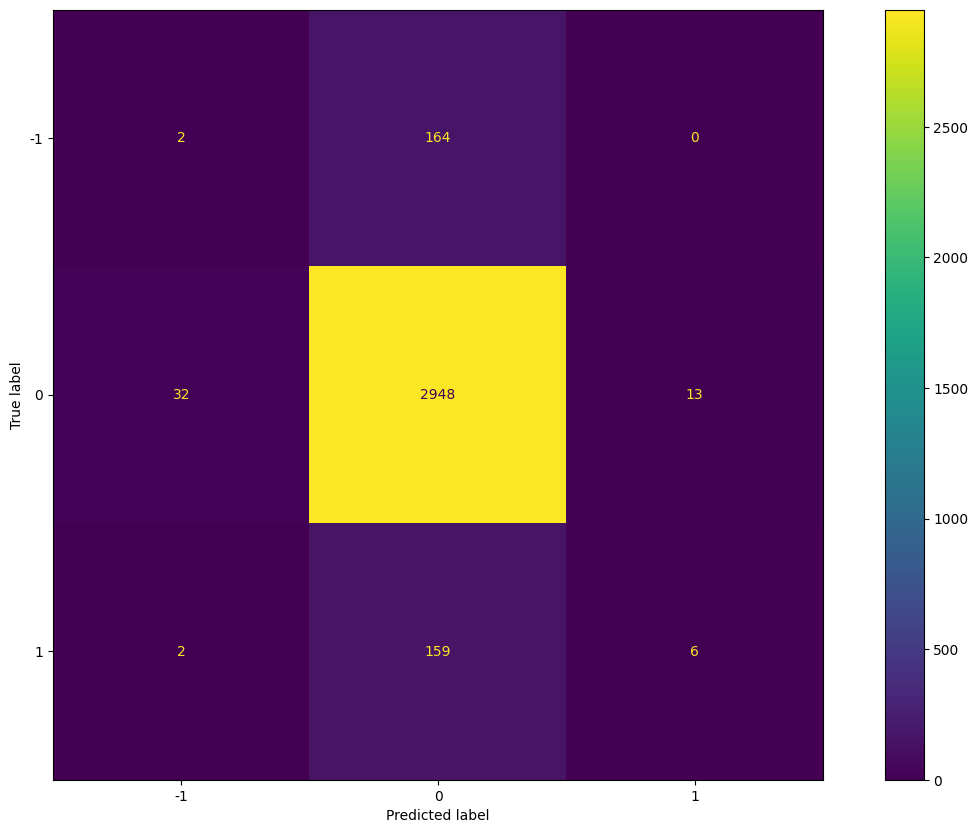

In [61]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## Общий рынок - RVI

In [62]:
p = 0.05

q_l = df_global.rvi_price_diff_percent.quantile(p)
q_u = df_global.rvi_price_diff_percent.quantile(1-p)

df_global['rvi_price_diff_cat'] = 1
df_global.loc[df_global['rvi_price_diff_percent'] <= q_l, 'rvi_price_diff_cat'] = 0
df_global.loc[df_global['rvi_price_diff_percent'] >= q_u, 'rvi_price_diff_cat'] = 2

df_global[['rvi_price_diff_cat']].groupby('rvi_price_diff_cat').value_counts()

rvi_price_diff_cat
0      666
1    11972
2      666
Name: count, dtype: int64

In [63]:
X, y = np.array(df_global['text_clear']), np.array(df_global['rvi_price_diff_cat'].values)

In [64]:
vectorizer = TfidfVectorizer(min_df=50)
vect_x = vectorizer.fit_transform(X)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(vect_x,
                                                    y,
                                                    random_state=23,
                                                    test_size=0.25,
                                                    stratify=y)

X_res, Y_res = X_train, y_train

In [66]:
train_x, valid_x, train_y, valid_y = train_test_split(X_res,
                                                      Y_res,
                                                      random_state=23,
                                                      test_size=0.25,
                                                      stratify=Y_res)

## SVC

In [67]:
def objective(trial):
    svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    svc_degree = trial.suggest_int('degree', 2, 5, 1, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    svc_c = trial.suggest_float("C", 1e-2, 1e2, log=True)
    clf = SVC(C=svc_c, gamma=svc_gamma, degree=svc_degree, kernel=svc_kernel)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [68]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="svc", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.36742617546068407
  Params: 
    kernel: linear
    degree: 4
    gamma: auto
    C: 22.590181902238598


0.3677344462321562


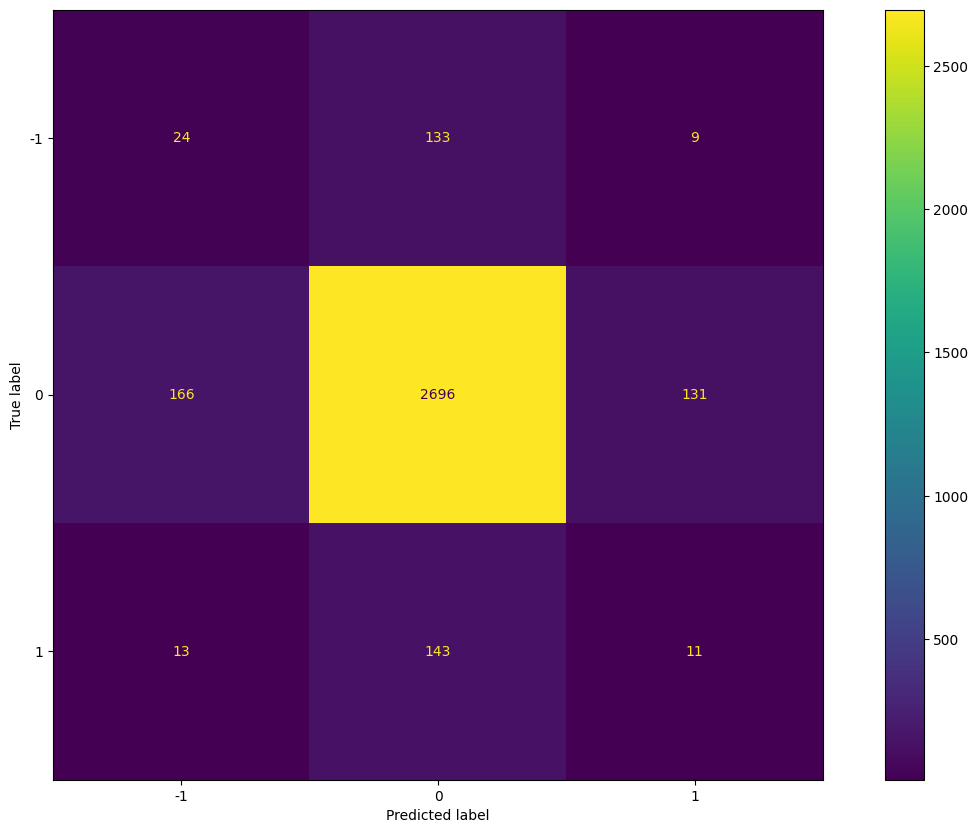

In [69]:
clf = SVC(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## KNN

In [70]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 3, 15, 1, log=True)
    knn_weights = trial.suggest_categorical('weights', ['uniform','distance'])
    knn_metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    clf = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [71]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="knn", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.3550553600442296
  Params: 
    n_neighbors: 3
    weights: distance
    metric: manhattan


0.3592966986389752


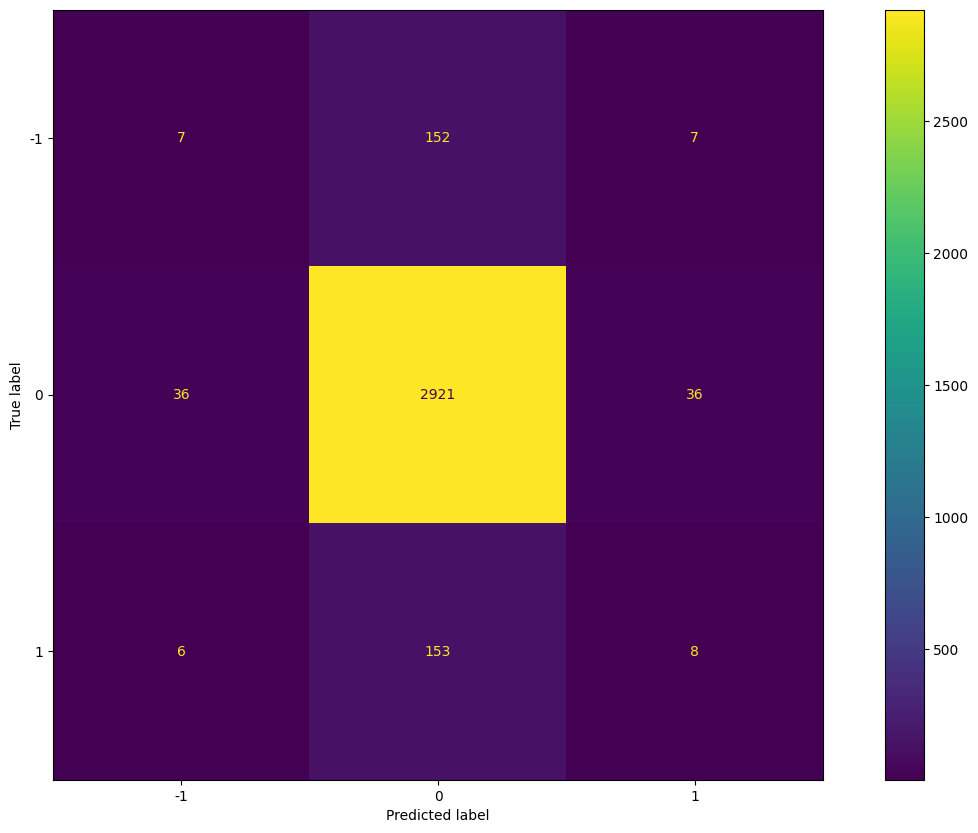

In [72]:
clf = KNeighborsClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## LogReg

In [73]:
def objective(trial):
    logreg_solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga','lbfgs'])
    logereg_C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    clf = LogisticRegression(multi_class='multinomial', solver=logreg_solver, C=logereg_C, max_iter=1000)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [74]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="logreg", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.3622794091119235
  Params: 
    solver: sag
    C: 39.340833758138125


0.3560446775882673


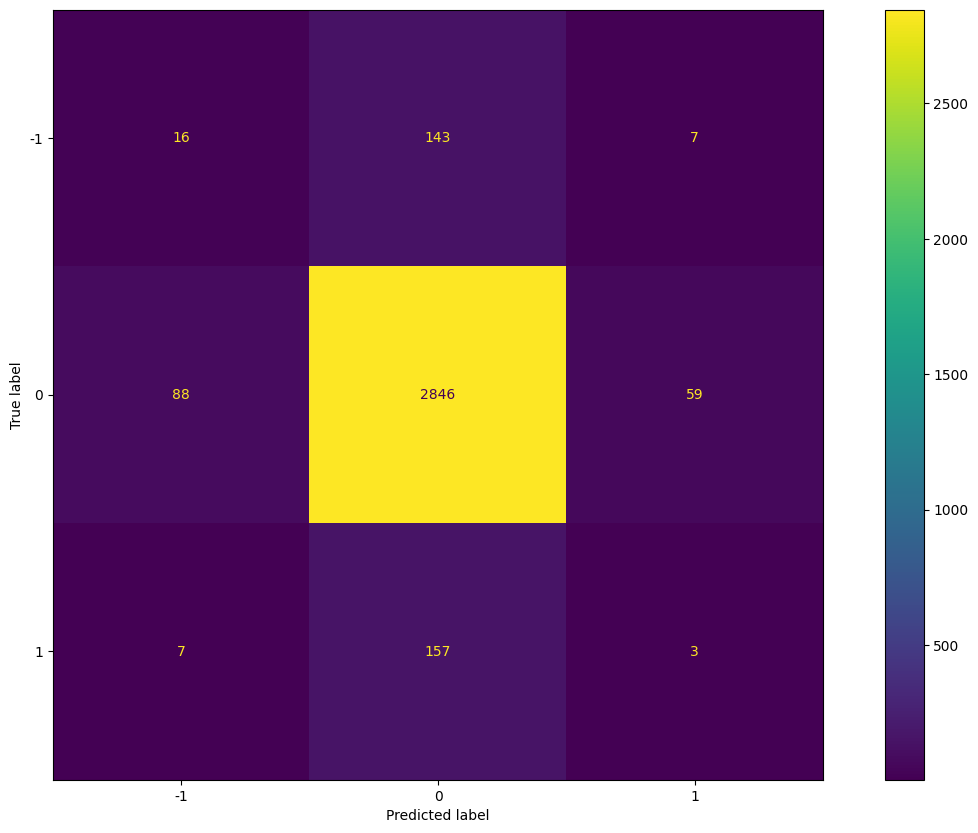

In [75]:
clf = LogisticRegression(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## RandomForest

In [76]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, log=True)
    max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [77]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="rf", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.3664000699340493
  Params: 
    n_estimators: 63
    max_depth: 10
    class_weight: balanced


0.3546664108460483


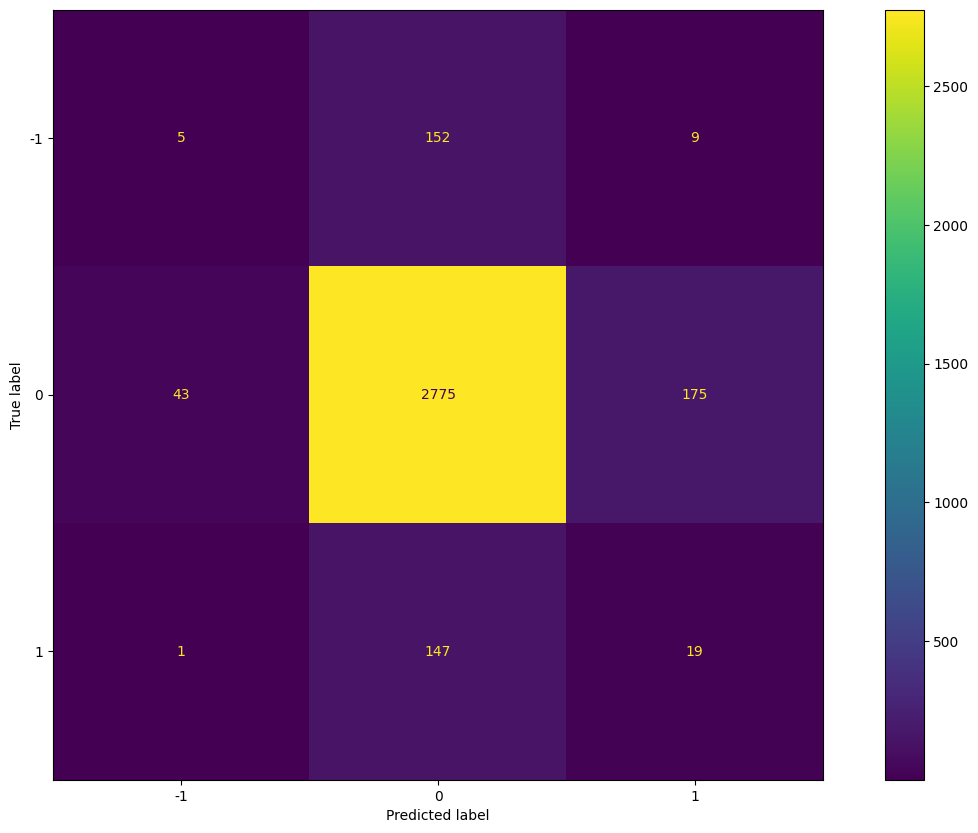

In [78]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## Общий рынок - Фьючерс на доллар

In [79]:
p = 0.05

q_l = df_global.usd_price_diff_percent.quantile(p)
q_u = df_global.usd_price_diff_percent.quantile(1-p)

df_global['usd_price_diff_cat'] = 1
df_global.loc[df_global['usd_price_diff_percent'] <= q_l, 'usd_price_diff_cat'] = 0
df_global.loc[df_global['usd_price_diff_percent'] >= q_u, 'usd_price_diff_cat'] = 2

df_global[['usd_price_diff_cat']].groupby('usd_price_diff_cat').value_counts()

usd_price_diff_cat
0      666
1    11972
2      666
Name: count, dtype: int64

In [80]:
X, y = np.array(df_global['text_clear']), np.array(df_global['usd_price_diff_cat'].values)

In [81]:
vectorizer = TfidfVectorizer(min_df=50)
vect_x = vectorizer.fit_transform(X)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(vect_x,
                                                    y,
                                                    random_state=23,
                                                    test_size=0.25,
                                                    stratify=y)

X_res, Y_res = X_train, y_train

In [83]:
train_x, valid_x, train_y, valid_y = train_test_split(X_res,
                                                      Y_res,
                                                      random_state=23,
                                                      test_size=0.25,
                                                      stratify=Y_res)

## SVC

In [84]:
def objective(trial):
    svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    svc_degree = trial.suggest_int('degree', 2, 5, 1, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    svc_c = trial.suggest_float("C", 1e-2, 1e2, log=True)
    clf = SVC(C=svc_c, gamma=svc_gamma, degree=svc_degree, kernel=svc_kernel)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [85]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="svc", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.37306344402380415
  Params: 
    kernel: poly
    degree: 2
    gamma: scale
    C: 2.9824472008421727


0.33326319208672145


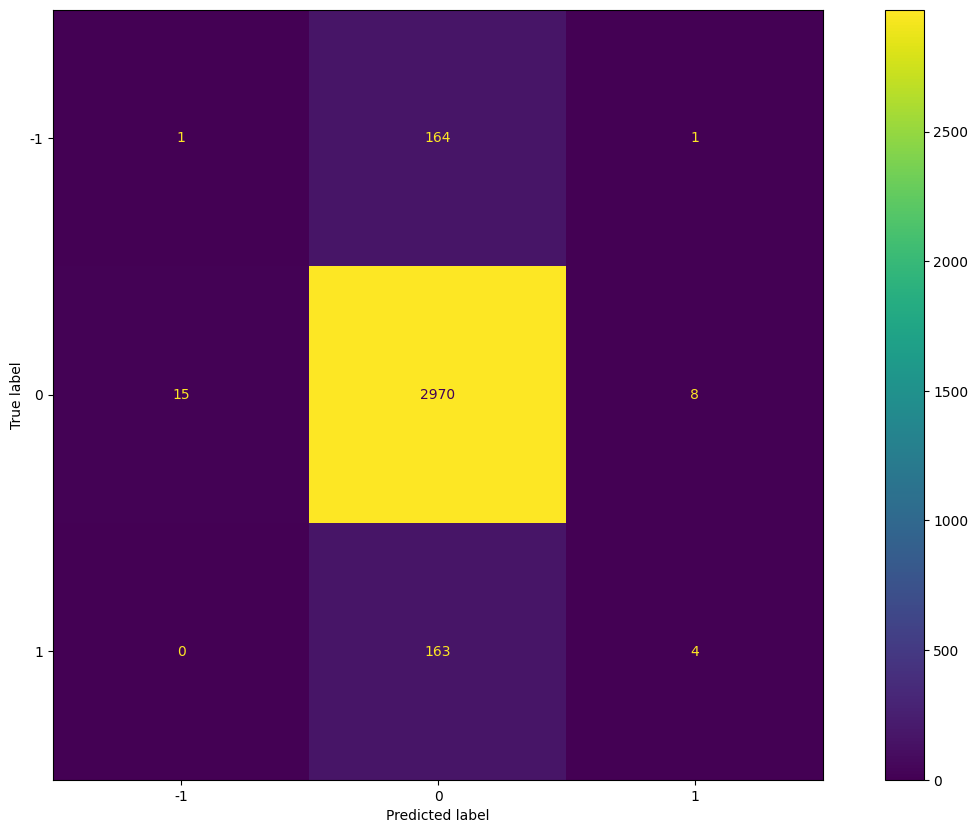

In [86]:
clf = SVC(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## KNN

In [87]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 3, 15, 1, log=True)
    knn_weights = trial.suggest_categorical('weights', ['uniform','distance'])
    knn_metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    clf = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [88]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="knn", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.3729921449466296
  Params: 
    n_neighbors: 3
    weights: distance
    metric: euclidean


0.35318711508348993


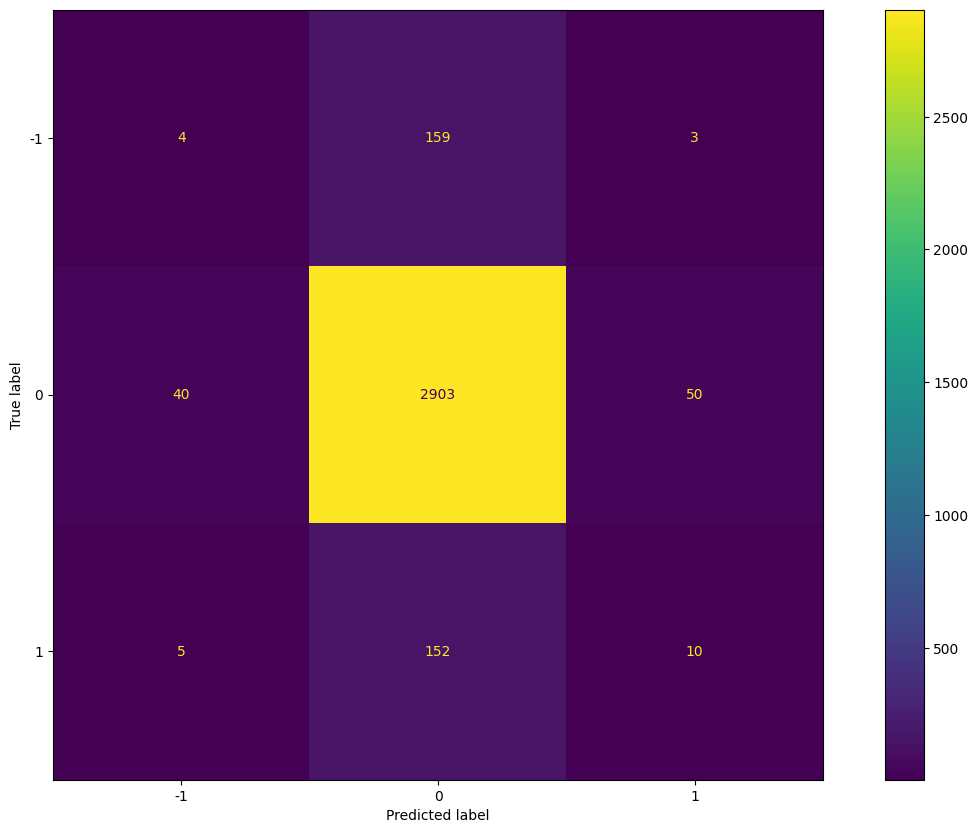

In [89]:
clf = KNeighborsClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## LogReg

In [90]:
def objective(trial):
    logreg_solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga','lbfgs'])
    logereg_C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    clf = LogisticRegression(multi_class='multinomial', solver=logreg_solver, C=logereg_C, max_iter=1000)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [91]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="logreg", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.37776405406968366
  Params: 
    solver: saga
    C: 24.998500585371122


c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.35686870570725326


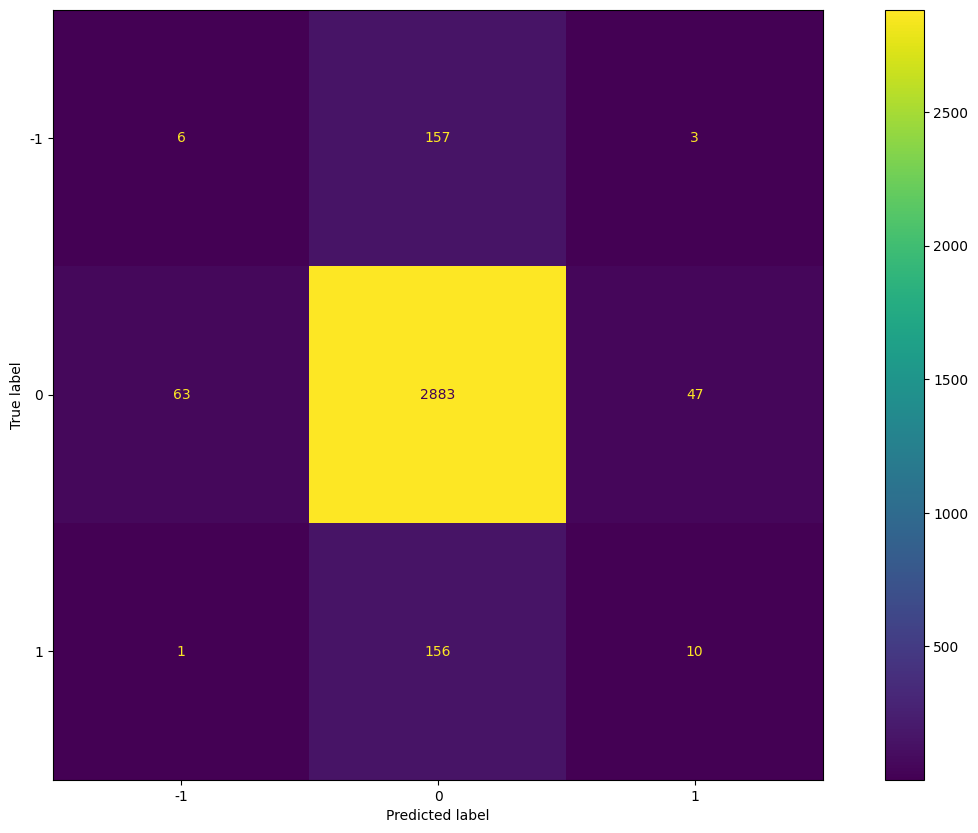

In [92]:
clf = LogisticRegression(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## RandomForest

In [93]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, log=True)
    max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [94]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="rf", direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.38666422982954723
  Params: 
    n_estimators: 66
    max_depth: 10
    class_weight: balanced_subsample


0.3527296256549714


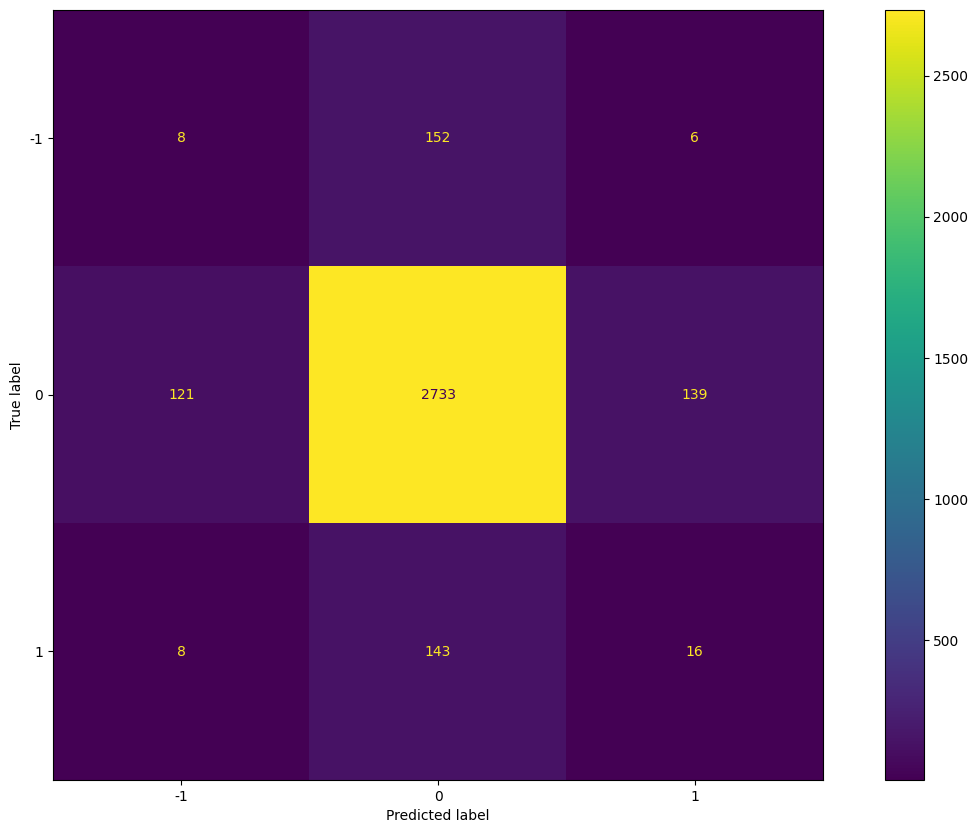

In [95]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)